## Machine Learning Waste Detection: TACO Dataset Processing

In this notebook, we process the TACO (Trash Annotations in Context) Dataset and generate TF Records files for each image containing the annotations.

#### Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import urllib.request
import cv2
import json

#### Step 1: Filter the dataset for relevant images and annotations

First get all of the annotations into a dataframe:

In [2]:
with open('/Users/gautamchauhan/Desktop/MAPS Internship Code and Data/Data/TACO/annotations.json') as json_data:
    data = json.load(json_data)
    df = pd.json_normalize(data)

In [3]:
df

,images,annotations,scene_annotations,licenses,categories,scene_categories,info.year,info.version,info.description,info.contributor,info.url,info.date_created
0,"[{'id': 0, 'width': 1537, 'height': 2049, 'fil...","[{'id': 1, 'image_id': 0, 'category_id': 6, 's...","[{'image_id': 0, 'background_ids': [1]}, {'ima...",[],"[{'supercategory': 'Aluminium foil', 'id': 0, ...","[{'id': 0, 'name': 'Clean'}, {'id': 1, 'name':...",2019,None,TACO,None,None,2019-12-19T16:11:15.258399+00:00


In [4]:
scene_categories = df["scene_categories"][0]
scene_categories

[{'id': 0, 'name': 'Clean'},
 {'id': 1, 'name': 'Indoor, Man-made'},
 {'id': 2, 'name': 'Pavement'},
 {'id': 3, 'name': 'Sand, Dirt, Pebbles'},
 {'id': 4, 'name': 'Trash'},
 {'id': 5, 'name': 'Vegetation'},
 {'id': 6, 'name': 'Water'}]

Filter the dataset according to the background scene. Specifically, we will filter out the "Indoor, Man-made" category, the "Pavement" category, the "Trash" and the "Clean" category because these images contain backgrounds which are unrealistic for our main dataset.

We will also filter category "7" out because this does not appear in the list of scene categories and I'm not sure what kind of background it refers to.

In [5]:
scene_annotations = df["scene_annotations"][0]
scene_annotations[0:10]

[{'image_id': 0, 'background_ids': [1]},
 {'image_id': 1, 'background_ids': [1]},
 {'image_id': 2, 'background_ids': [2]},
 {'image_id': 3, 'background_ids': [5]},
 {'image_id': 4, 'background_ids': [5]},
 {'image_id': 5, 'background_ids': [1]},
 {'image_id': 6, 'background_ids': [1, 7]},
 {'image_id': 7, 'background_ids': [2]},
 {'image_id': 8, 'background_ids': [2, 5]},
 {'image_id': 9, 'background_ids': [1]}]

In [6]:
# Find all the image ids we want to remove
unsuitable_ids = []
for image_dict in scene_annotations:
    background_ids = image_dict["background_ids"]
    if 1 in background_ids or 2 in background_ids or 7 in background_ids or 4 in background_ids or 0 in background_ids:
        unsuitable_ids.append(image_dict["image_id"])

# All the image ids from 0 to 1499
image_ids = [i for i in range(1500)]

# Remove the unsuitable ids
filtered_ids = []
for id in image_ids:
    if id not in unsuitable_ids:
        filtered_ids.append(id)

# Check the number of unique unsuitable ids and suitable ids adds up to 1500
print(len(list(set(unsuitable_ids))))
print(len(list(set(filtered_ids))))

980
520


In [7]:
filtered_ids[0:10]

[3, 4, 10, 11, 18, 25, 26, 27, 28, 29]

For each of the relevant ids, find the corresponding image, download it and add it to a list of loaded images.

In [8]:
image_data = df["images"][0]
image_data[0:5]

[{'id': 0,
  'width': 1537,
  'height': 2049,
  'file_name': 'batch_1/000006.jpg',
  'license': None,
  'flickr_url': 'https://farm66.staticflickr.com/65535/33978196618_e30a59e0a8_o.png',
  'coco_url': None,
  'date_captured': None,
  'flickr_640_url': 'https://farm66.staticflickr.com/65535/33978196618_632623b4fc_z.jpg'},
 {'id': 1,
  'width': 1537,
  'height': 2049,
  'file_name': 'batch_1/000008.jpg',
  'license': None,
  'flickr_url': 'https://farm66.staticflickr.com/65535/47803331152_ee00755a2e_o.png',
  'coco_url': None,
  'date_captured': None,
  'flickr_640_url': 'https://farm66.staticflickr.com/65535/47803331152_19beae025a_z.jpg'},
 {'id': 2,
  'width': 1537,
  'height': 2049,
  'file_name': 'batch_1/000010.jpg',
  'license': None,
  'flickr_url': 'https://farm66.staticflickr.com/65535/40888872753_08ffb24902_o.png',
  'coco_url': None,
  'date_captured': None,
  'flickr_640_url': 'https://farm66.staticflickr.com/65535/40888872753_631ab0f441_z.jpg'},
 {'id': 3,
  'width': 2049,


In [9]:
loaded_images = []

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

for datapoint in image_data:
    if datapoint["id"] in filtered_ids:
        url = datapoint["flickr_url"]
        req = urllib.request.Request(url, headers=headers)
        with urllib.request.urlopen(req) as response:
            image_data_bytes = response.read()
            image_data_array = np.frombuffer(image_data_bytes, np.uint8)
            img = cv2.imdecode(image_data_array, cv2.IMREAD_COLOR)
        loaded_images.append(img)

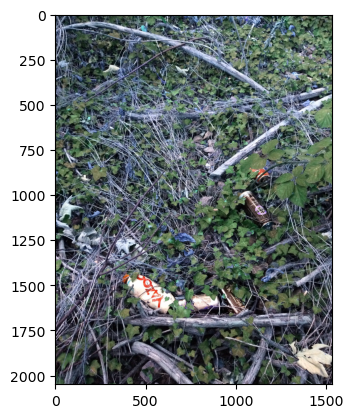

In [10]:
plt.imshow(loaded_images[7])

In [11]:
len(loaded_images)

520

For each of the relevant ids, find the corresponding bounding boxes. Then create a dictionary where the keys are image filenames and the values are a list of objects in that image, each in the form {"label":label,"box":bounding box}. 

We will eventually use this to create XML files for each of the images, so we need to change the bounding box formats from the COCO JSON format which is present in the TACO dataset to the PASCAL VOC format. This can be achieved through the function below.

In [12]:
annotations = df["annotations"][0]

In [13]:
def change_bbox_format(bbox):
    """Change the bounding box format from COCO where it is [xmin,ymin,width,height] to PASCAL VOC where it is [xmin,ymin,xmax,ymax]
    Args:
        bbox: the original bounding box specification in the form [xmin,ymin,width,height]
    Returns:
        new_bbox: the bounding box specification in the new form [xmin,ymin,xmax,ymax]
    """
    
    xmin = bbox[0]
    ymin = bbox[1]
    width = bbox[2]
    height = bbox[3]
    # Convert to format [xmin,ymin,xmax,ymax]
    new_bbox = [xmin,ymin,xmin+width,ymin+height]
    return new_bbox

In [14]:
dataset = {}
for datapoint in annotations:
    id = datapoint["image_id"]
    filename = str(id) + ".png"
    bbox = datapoint["bbox"]
    bbox = change_bbox_format(bbox)
    label = "Trash"
    object_detection = {"label":label,"box":bbox}
    if id in filtered_ids:
        try:
            # If the image already exists in the dataset, add another object to the list
            dataset[filename].append(object_detection)
        except:
            # If this object is the first one for a particular image, add a new entry to the dictionary of images "dataset"
            dataset[filename] = [object_detection]

In [15]:
dataset["3.png"]

[{'label': 'Trash', 'box': [209.0, 920.0, 663.0, 1482.0]},
 {'label': 'Trash', 'box': [1212.0, 822.0, 1391.0, 1268.0]},
 {'label': 'Trash', 'box': [634.0, 1442.0, 663.0, 1481.0]},
 {'label': 'Trash', 'box': [589.0, 548.0, 930.0, 953.0]}]

In [16]:
len(dataset)

520

#### Step 2: Write the images to a file, and convert the corresponding annotations to the XML format

In [17]:
import os
import xml.etree.ElementTree as ET
from xml.dom import minidom

Function to create XML file from the image data (in the Pascal VOC format, to match those from LabelImg)

In [18]:
def create_voc_xml(image_filename, objects, image_size, output_path):
    """
    Creates a PASCAL VOC XML file for the annotations corresponding to a particular image

    Args:
        image_filename: The name of the image file.
        objects: A list of dictionaries, each with 'label' and 'box'.
        image_size: A tuple of (width, height, depth).
        output_path: The path to save the XML file.
    """
    width, height, depth = image_size
    
    # Create the root element <annotation>
    annotation = ET.Element('annotation')

    # Add child elements to <annotation>
    ET.SubElement(annotation, 'folder').text = os.path.basename(os.path.dirname(output_path))
    ET.SubElement(annotation, 'filename').text = image_filename
    ET.SubElement(annotation, 'path').text = os.path.join(os.path.dirname(output_path), image_filename)

    source = ET.SubElement(annotation, 'source')
    ET.SubElement(source, 'database').text = 'Unknown'

    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(width)
    ET.SubElement(size, 'height').text = str(height)
    ET.SubElement(size, 'depth').text = str(depth)

    ET.SubElement(annotation, 'segmented').text = '0'

    # Add <object> elements for each bounding box
    for obj in objects:
        obj_elem = ET.SubElement(annotation, 'object')
        ET.SubElement(obj_elem, 'name').text = obj['label']
        ET.SubElement(obj_elem, 'pose').text = 'Unspecified'
        ET.SubElement(obj_elem, 'truncated').text = '0'
        ET.SubElement(obj_elem, 'difficult').text = '0'
        
        bndbox = ET.SubElement(obj_elem, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(obj['box'][0])
        ET.SubElement(bndbox, 'ymin').text = str(obj['box'][1])
        ET.SubElement(bndbox, 'xmax').text = str(obj['box'][2])
        ET.SubElement(bndbox, 'ymax').text = str(obj['box'][3])

    # Pretty print the XML
    rough_string = ET.tostring(annotation, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    pretty_xml = reparsed.toprettyxml(indent="  ")

    # Write the pretty-printed XML to a file
    with open(output_path, 'w') as f:
        f.write(pretty_xml)

In [19]:
TACO_ANNOTATIONS_PATH = '/Users/gautamchauhan/Desktop/MAPS Internship Code and Data/Data/TACO Annotations/'

In [20]:
for image_filename in dataset.keys():
    objects = dataset[image_filename]
    # Depth = 3 because there are 3 channels: RGB
    image_size = (image_data[int(image_filename[0])]["width"],image_data[int(image_filename[0])]["height"],3)
    # Remove the .png extension from the filename and add .xml
    output_path = TACO_ANNOTATIONS_PATH + image_filename[:-4] + ".xml"
    create_voc_xml(image_filename,objects,image_size,output_path)

Save the images themselves in the same directory:

In [21]:
for i in range(len(loaded_images)):
    image_filename = list(dataset.keys())[i]
    image = loaded_images[i]
    output_path = TACO_ANNOTATIONS_PATH + image_filename
    cv2.imwrite(output_path, image)